In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os,re,nltk,difflib
sns.set_style("whitegrid")

def ding():
    os.system('afplay /System/Library/Sounds/Submarine.aiff')

### Choisir le match

In [2]:
# rep="/Users/gilles/Downloads/Traitements_GB/"
rep="/Users/gilles/Github/AMBK-SportsCom/Chaines/Traitements_GB/"
match="FR-AR"
# match="FR-NZ"
nFile="%s-fr-GB.xlsx"%match

In [3]:
df=pd.read_excel(rep+nFile,index_col=0)

In [4]:
df.iloc[80:120]

,Transcription,Cat,Lemme,Modif,Referent,numChaine,chaineIndex,chaineDep,chaineApp,oldReferent,oldNumChaine,oldChaineIndex,oldChaineDep
80,.,SENT,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,dans,PRP,dans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,ce,PRO:DEM,ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,cas,NOM,cas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,-là,ADV,là,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,",",PUN,",",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,on,PRO:PER,on,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,peut,VER:pres,pouvoir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,trouver,VER:infi,trouver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,une,DET:ART,un,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
nbMots=len(df[~df.Cat.isin(["PUN","SENT"])])
print(match,nbMots)

FR-AR 16961


### Calcul des chaines

In [6]:
maxNumChaine=int(df.numChaine.max())
maxNumChaine

1088

In [7]:
chaines={}
lChaines={}
for num in range(maxNumChaine):
    n=num+1
    dfChaine=df.loc[df.numChaine==n]
    try:
        chaines[n]={"ref":dfChaine.Referent.values[0],"chaine":{}}
        indexMax=int(dfChaine.chaineIndex.max())
        if indexMax not in lChaines:
            lChaines[indexMax]=0
        lChaines[indexMax]+=1
        for ind in range(indexMax):
            i=ind+1
            dfIndex=dfChaine.loc[dfChaine.chaineIndex==i]
            chaines[n]["chaine"][i]=dfIndex[["Cat","Transcription"]].to_dict()
    except:
        print("pb",n,end=", ")
        # display(dfChaine)
print()
print(lChaines)

pb 17, pb 30, pb 37, pb 88, pb 139, pb 146, pb 183, pb 184, pb 185, pb 190, pb 200, pb 420, pb 508, pb 511, pb 518, pb 539, pb 551, pb 561, pb 570, pb 572, pb 582, pb 583, pb 584, pb 603, pb 604, pb 617, pb 622, pb 638, pb 670, pb 673, pb 674, pb 737, pb 738, pb 764, pb 865, pb 877, pb 909, pb 930, pb 984, pb 1009, pb 1068, 
{1: 662, 4: 42, 3: 119, 2: 164, 9: 7, 5: 20, 12: 1, 6: 17, 11: 4, 13: 2, 8: 1, 7: 7, 10: 1}


#### Calcul de la longueur maximale des chaines

In [8]:
maxLChaines=max(lChaines.keys())
for l in range(maxLChaines):
    if l+1 not in lChaines:
        lChaines[l+1]=0
colors = sns.color_palette('pastel',n_colors=maxLChaines)

#### Nombre de chaines par longueur

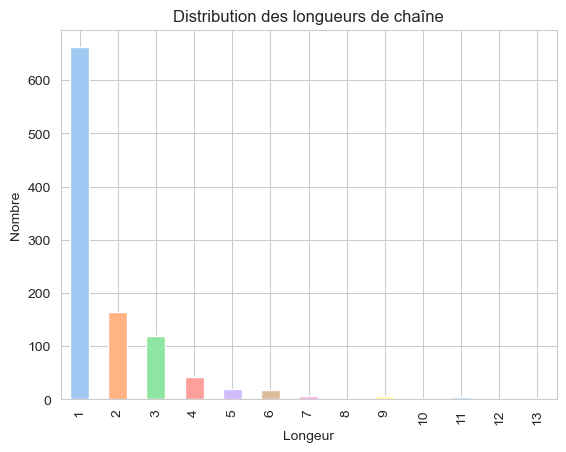

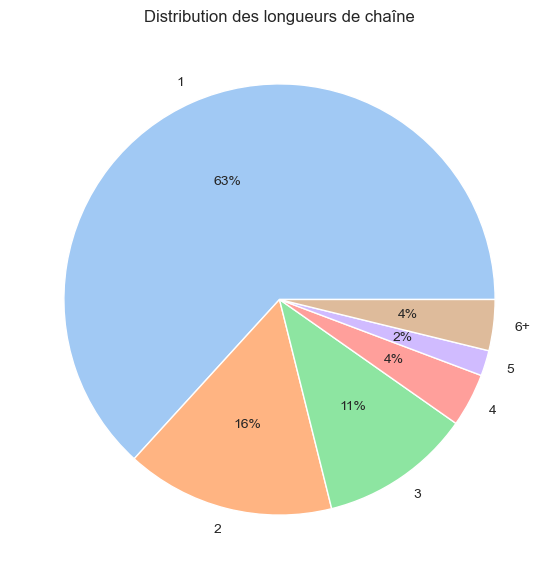

In [9]:
pieCut=5
dfDistLong=pd.DataFrame.from_dict(lChaines,orient="index").sort_index()
dfDistLong.name="Longueur de chaine"
dfDistLong.plot.bar(y=0,color=colors,ylabel="Nombre",xlabel="Longeur",title="Distribution des longueurs de chaîne",legend=False)
plt.savefig("JE-BP-LongChaines-%s.pdf"%match)
dfTemp=dfDistLong[:pieCut].copy()
autres=dfDistLong[pieCut:].sum()
autres.index=["%d+"%(pieCut+1)]
dfTemp=pd.concat([dfTemp,autres])
ax=dfTemp.plot.pie(y=0,colors=colors, autopct='%.0f%%',title="Distribution des longueurs de chaîne",figsize=(7,7),legend=False)
ax.set_ylabel(None)
dfTemp.to_excel("DistLongChaine-%s.xlsx"%match)
plt.savefig("JE-PC-LongChaines-%s.pdf"%match)

#### Nombre de chaines par longueur par référent

In [10]:
refChaines={}
lRefChaines={}#
# print(lRefChaines)
for k,v in chaines.items():
    ref=chaines[k]["ref"]
    chaine=chaines[k]["chaine"]
    if ref not in refChaines:
        refChaines[ref]=[]
        lRefChaines[ref]={i:0 for i in range(1,maxLChaines+1)}
    refChaines[ref].append(chaines[k]["chaine"])
    longueur=max(chaines[k]["chaine"].keys())
    if longueur not in lRefChaines[ref]:
        lRefChaines[ref][longueur]=0
    lRefChaines[ref][longueur]+=1
dfRefChaines=pd.DataFrame.from_dict(lRefChaines).sort_index().T

dfRefChaines["sum"]=dfRefChaines.iloc[:,0:maxLChaines].sum(axis=1)
dfRefChaines=dfRefChaines.sort_values(by='sum',ascending=False)
dfRefChaines=dfRefChaines.drop(columns="sum")
display(dfRefChaines.head())

,1,2,3,4,5,6,7,8,9,10,11,12,13
GTF,50,26,16,8,3,2,0,0,2,0,0,0,0
GTA,58,12,10,2,2,5,2,0,0,0,1,0,1
J-F9,46,4,3,2,1,2,0,0,0,0,0,0,0
J-F10,32,7,4,3,3,1,0,0,0,0,0,0,0
thierry,34,4,2,1,0,0,0,0,0,0,1,0,1


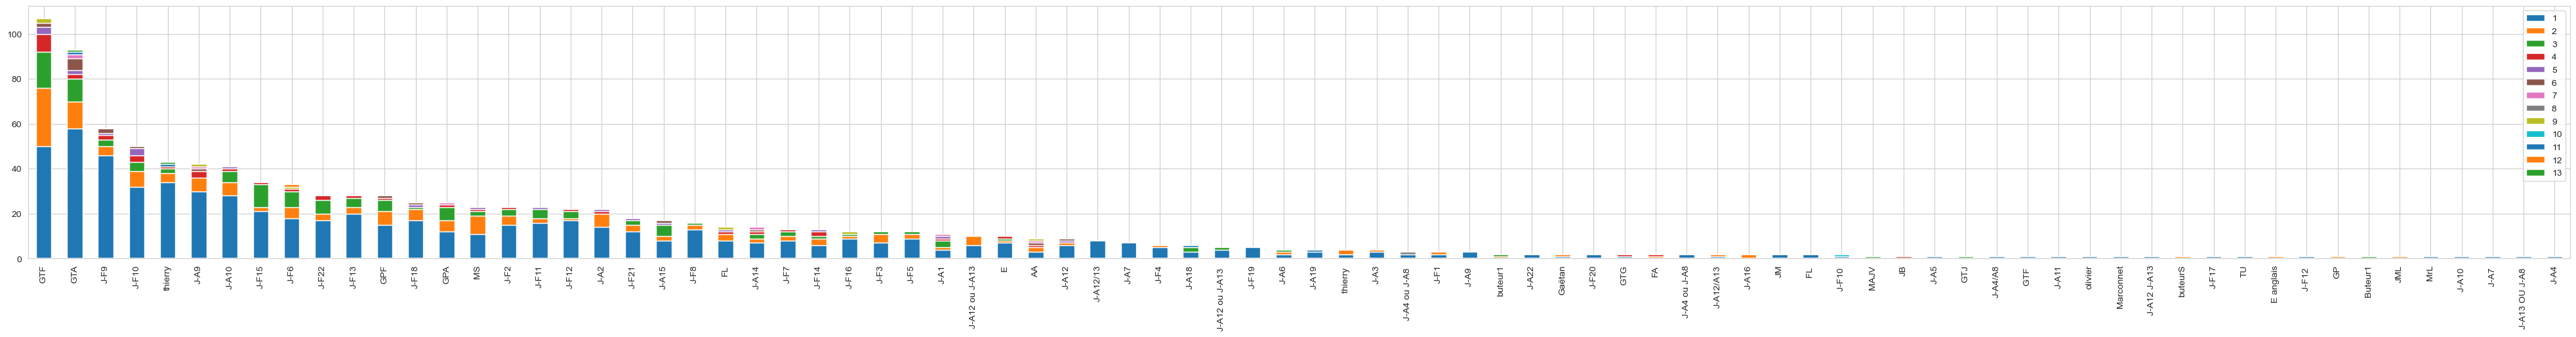

In [11]:
dfRefChaines.plot(kind="bar",stacked=True,figsize=(50,5))
plt.savefig("JE-SB-DistChaines-%s.pdf"%match)

#### Calcul du nombre de reprises par catégorie
- chaineIndex renseignée
- chaineDep différent de root (≠0)

In [12]:
print(match)
catTable=df[(df.chaineIndex.notnull())&(df.chaineDep>0)].groupby("Cat").count()[["Lemme"]].loc["NAM PRO:REL PRO:PER NOM DET:POS PRO:DEM PRO:IND".split(" ")]
display(catTable)
print(catTable.sum())

FR-AR


,Lemme
Cat,
NAM,12
PRO:REL,175
PRO:PER,462
NOM,27
DET:POS,56
PRO:DEM,2
PRO:IND,1


Lemme    735
dtype: int64


#### Détail des reprises

In [13]:
dfGroupReprises=df[(df.chaineIndex.notnull())&(df.chaineDep>0)].groupby(["numChaine","chaineIndex"])[["Cat","Transcription"]].sum()
dfGroupReprises

Cat Transcription
numChaine chaineIndex                       
4.0       2.0          PRO:PER            il
          3.0          PRO:PER            il
          4.0          DET:POS           ses
7.0       3.0          PRO:REL           qui
9.0       2.0          PRO:PER            il
...                        ...           ...
1080.0    2.0          DET:POS           son
          4.0          DET:POS           son
          5.0          PRO:PER            il
          6.0          PRO:PER            il
1082.0    2.0          PRO:REL           qui

[698 rows x 2 columns]

In [14]:
print(match,len(dfGroupReprises),nbMots,"%2.1f%%"%(len(dfGroupReprises)/nbMots*100))

FR-AR 698 16961 4.1%


#### Détail des références

In [15]:
dfGroupeReferents=df[(df.chaineIndex.notnull())].groupby(["numChaine","chaineIndex"])[["Cat","Transcription"]].agg(" ".join)
dfGroupeReferents

Cat Transcription
numChaine chaineIndex                       
1.0       1.0          NAM NAM  David Skrela
2.0       1.0              NOM       Roncero
3.0       1.0              NAM        Pichot
4.0       1.0              NAM     Hernandez
          2.0          PRO:PER            il
...                        ...           ...
1085.0    1.0              NAM      Corletto
          2.0              NAM      Corletto
1086.0    1.0              NAM        France
1087.0    1.0              ADJ     Argentine
1088.0    1.0              NAM       Thierry

[1811 rows x 2 columns]

In [16]:
print(match,len(dfGroupeReferents),nbMots,"%2.1f%%"%(len(dfGroupeReferents)/nbMots*100))

FR-AR 1811 16961 10.7%


In [18]:
print(dfGroupeReferents.to_string())

                                                                           Cat                                                          Transcription
numChaine chaineIndex                                                                                                                                
1.0       1.0                                                          NAM NAM                                                           David Skrela
2.0       1.0                                                              NOM                                                                Roncero
3.0       1.0                                                              NAM                                                                 Pichot
4.0       1.0                                                              NAM                                                              Hernandez
          2.0                                                          PRO:PER                      

# Rapprochements entre chaines et autres données

In [19]:
dfGen=pd.read_csv(rep+"CorrespondancesAction-PlayVsColourVsSupportaire.csv",sep=";")

In [20]:
dfGen.columns="lNum tDeb tFin penalite type event action actComm comm rem1 rem2 err1 err2 commType commTypeCorr".split(" ")

In [21]:
dTours=dfGen.loc[dfGen.comm.notnull()][["comm","commType","tDeb","tFin"]].to_dict(orient="index")
lTours=[v for k,v in dTours.items()]
# lTours

In [22]:
nTours={}
for nT,tour in enumerate(lTours):
    if not tour["comm"].startswith("PROB"):
        refComm,comm=tour["comm"].split(" ",1)
        nTours[nT]=(nltk.wordpunct_tokenize(comm), 
                    refComm, tour["commType"], tour["tDeb"], tour["tFin"])
# nTours

In [23]:
def nextMot(iT,iM):
    # print("nM",nM,"iM",iM,"iT",iT,len(nTours[iT][0])-nPunct)
    if iM+1<len(nTours[iT][0]):
        rM=iM+1
        rT=iT
        rPrevM=prevM
        rPunct=nPunct
        print("next word",rM,len(nTours[iT][0])-nPunct)
    else:
        print("next turn")
        rT=iT+1
        rPrevM=prevM+iM+1+nPunct
        rM=0
        rPunct=0
    return rT,rM,rPrevM,rPunct
    
iT=0
prevM=0
iM=0
nPunct=0
for nM,mot in enumerate(df.Transcription.to_list()):
    print(nM-prevM,iM,mot)
    if mot in ",.?!":
        nPunct+=1
        print("sauter",nM-prevM,len(nTours[iT][0])-nPunct)
        if iM==len(nTours[iT][0]):
            print("ponctuation finale")
            iT+=1
            prevM+=iM+nPunct
            iM=0
            nPunct=0
    elif mot==nTours[iT][0][iM]:
        print (nTours[iT][1:])
        iT,iM,prevM,nPunct=nextMot(iT,iM)
    else:
        print("pb",nM,iM,prevM,mot,nTours[iT][0][iM])
        iT,iM,prevM,rPunct=nextMot(iT,iM)


0 0 après
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 1 22
1 1 avoir
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 2 22
2 2 demandé
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 3 22
3 3 si
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 4 22
4 4 tout
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 5 22
5 5 le
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 6 22
6 6 monde
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 7 22
7 7 était
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 8 22
8 8 prêt
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 9 22
9 9 ,
sauter 9 21
10 9 le
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 10 21
11 10 coup
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')
next word 11 21
12 11 d'

KeyError: 385

In [60]:
trans=[]
transNum={}
for n,t in enumerate(df.Transcription.to_list()):
    print(n)
    if str(t) not in list(".:,;!?")+["..."]:
        chunks=[c for c in re.split("[-']",str(t)) if c!=""]
        # if "-" in str(t):
        #     print(t,chunks)
        for chunk in chunks:
            trans.append(chunk.strip("#"))
            if n not in transNum:
                transNum[n]=[]
            transNum[n].append(len(trans)-1)
            print(chunk)
trans

0
après
1
avoir
2
demandé
3
si
4
tout
5
le
6
monde
7
était
8
prêt
9
10
le
11
coup
12
d
13
envoi
14
de
15
la
16
coupe
17
du
18
monde
19
deux
20
mille
21
sept
22
est
23
donné
24
par
25
David
26
Skrela
27
28
allez
29
de
30
suite
31
dans
32
le
33
camp
34
euh
35
argentin
36
37
avec
38
un
39
départ
40
de
41
Roncero
42
43
Pichot
44
a
45
appelé
46
le
47
ballon
48
49
pour
50
Hernandez
51
52
avec
53
le
54
pied
55
droit
56
57
pour
58
trouver
59
une
60
très
61
jolie
62
touche
63
64
direct
65
il
66
en
67
avait
68
le
69
droit
70
71
il
72
était
73
à
74
l
75
intérieur
76
de
77
ses
78
vingt
deux
79
mètres
80
81
dans
82
ce
83
cas
84
là
85
86
on
87
peut
88
trouver
89
une
90
touche
91
92
directement
93
94
alors
95
la
96
touche
97
98
ça
99
ça
100
sera
101
une
102
des
103
clefs
104
de
105
cette
106
rencontre
107
108
le
109
bloc
110
français
111
112
contre
113
le
114
bloc
115
argentin
116
117
lancer
118
pour
119
le
120
capitaine
121
de
122
l
123
équipe
124
de
125
France
126
Raphaël
127
Ibanez
128
129
qui
130

['après',
 'avoir',
 'demandé',
 'si',
 'tout',
 'le',
 'monde',
 'était',
 'prêt',
 'le',
 'coup',
 'd',
 'envoi',
 'de',
 'la',
 'coupe',
 'du',
 'monde',
 'deux',
 'mille',
 'sept',
 'est',
 'donné',
 'par',
 'David',
 'Skrela',
 'allez',
 'de',
 'suite',
 'dans',
 'le',
 'camp',
 'euh',
 'argentin',
 'avec',
 'un',
 'départ',
 'de',
 'Roncero',
 'Pichot',
 'a',
 'appelé',
 'le',
 'ballon',
 'pour',
 'Hernandez',
 'avec',
 'le',
 'pied',
 'droit',
 'pour',
 'trouver',
 'une',
 'très',
 'jolie',
 'touche',
 'direct',
 'il',
 'en',
 'avait',
 'le',
 'droit',
 'il',
 'était',
 'à',
 'l',
 'intérieur',
 'de',
 'ses',
 'vingt',
 'deux',
 'mètres',
 'dans',
 'ce',
 'cas',
 'là',
 'on',
 'peut',
 'trouver',
 'une',
 'touche',
 'directement',
 'alors',
 'la',
 'touche',
 'ça',
 'ça',
 'sera',
 'une',
 'des',
 'clefs',
 'de',
 'cette',
 'rencontre',
 'le',
 'bloc',
 'français',
 'contre',
 'le',
 'bloc',
 'argentin',
 'lancer',
 'pour',
 'le',
 'capitaine',
 'de',
 'l',
 'équipe',
 'de',
 'F

In [64]:
dTransNum={}
for k,v in transNum.items():
    for elt in v:
        dTransNum[elt]=k
dTransNum

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 28,
 27: 29,
 28: 30,
 29: 31,
 30: 32,
 31: 33,
 32: 34,
 33: 35,
 34: 37,
 35: 38,
 36: 39,
 37: 40,
 38: 41,
 39: 43,
 40: 44,
 41: 45,
 42: 46,
 43: 47,
 44: 49,
 45: 50,
 46: 52,
 47: 53,
 48: 54,
 49: 55,
 50: 57,
 51: 58,
 52: 59,
 53: 60,
 54: 61,
 55: 62,
 56: 64,
 57: 65,
 58: 66,
 59: 67,
 60: 68,
 61: 69,
 62: 71,
 63: 72,
 64: 73,
 65: 74,
 66: 75,
 67: 76,
 68: 77,
 69: 78,
 70: 78,
 71: 79,
 72: 81,
 73: 82,
 74: 83,
 75: 84,
 76: 86,
 77: 87,
 78: 88,
 79: 89,
 80: 90,
 81: 92,
 82: 94,
 83: 95,
 84: 96,
 85: 98,
 86: 99,
 87: 100,
 88: 101,
 89: 102,
 90: 103,
 91: 104,
 92: 105,
 93: 106,
 94: 108,
 95: 109,
 96: 110,
 97: 112,
 98: 113,
 99: 114,
 100: 115,
 101: 117,
 102: 118,
 103: 119,
 104: 120,
 105: 121,
 106: 122,
 107: 123,
 108: 124,
 109: 1

In [65]:
def chaineSyn(ops):
    result=[]
    for op in ops:
        if op[0]=="equal":
            for i in range(op[3],op[4]):
                result.append(i)
    return result

In [69]:
i=0
nSkips=[312,330,1000,1106,1112,1124,18,96,108,128,172,184,193,
        200,247,256,257,269,445,480,498,504,515,533,547,550, 
        636,668,717,747,754,775,788,799,806,832,838,979,
        1036,1049,1050,1051,1064,1065,1067,1068,1069,1071,
        1101,1114,1119,1173,1175,1222,1227,1228,1233,1235,1246,1261,1262,
        1310,1332,1354,1413,1496,1528,1550,1563,1570,1571,1592,1595,
        1658,1681,1694,1700,1715,1721,1726,1728,1758,1764,1823,1943,2007,2031,2082,2123,
        2332,
        192,423,645,725,794,1023,1307,1702,1760,1762,1781,1795,1796,1824,1838,1876,
        1915,1928,1933,1934,1936,1937,1948,1950,1951,1958,1974,1996,
        2009,2013,2025,2027,2036,2079,2114,2121,2128,2132,2133,2136,2138,2140,2177,
        2180,2207,2225,2235,2288,2311,2318,2320,2357,2367,
        2400,2444,2449,2450,2462,2465,2483,2502,2503,2547,2556,2596,2628,2654]
newSkips=[]
# nSkips=[]
# for t in nTours:
for t in range(5):
    a=nTours[t][0]
    b=trans[i:i+250]
    c=nTours[t][1:]
    if t in nSkips:
        print (t)
        print(a)
        print(trans[i:i+len(a)+10])
        print()
        continue
    s=difflib.SequenceMatcher(lambda x: x in ",';.?!-*".split()+["...","hein","ha","ah","hé","oui"],a,b)
    opcodes=s.get_opcodes()
    synEqs=chaineSyn(opcodes)
    for synEq in synEqs:
        print(synEq,b[synEq], end=" ")
        idx=dTransNum[synEq]
        print(idx,df.iloc[i+idx].Transcription,end=" ")
        print()
    print()
    if opcodes[-1][0]=="insert":
        last=opcodes[-2]
        # print (opcodes)
        aLast=last[2]
        bLast=last[4]
        print (t,i+bLast)
        print(a[:aLast])
        print(b[:bLast])
        print(c)
        i+=bLast
        print()
    else:
        print("==============")
        print(t,a,trans[i:i+len(a)+10])
        newSkips.append(t)
        print("==============")
        # print(a)
        # print(b[:len(a)+10])
        # print()


0 après 0 après 
1 avoir 1 avoir 
2 demandé 2 demandé 
3 si 3 si 
4 tout 4 tout 
5 le 5 le 
6 monde 6 monde 
7 était 7 était 
8 prêt 8 prêt 
9 le 10 le 
10 coup 11 coup 
11 d 12 d' 
12 envoi 13 envoi 
13 de 14 de 
14 la 15 la 
15 coupe 16 coupe 
16 du 17 du 
17 monde 18 monde 
18 deux 19 deux 
19 mille 20 mille 
20 sept 21 sept 

0 21
['après', 'avoir', 'demandé', 'si', 'tout', 'le', 'monde', 'était', 'prêt', 'le', 'coup', 'd', "'", 'envoi', 'de', 'la', 'coupe', 'du', 'monde', 'deux', 'mille', 'sept']
['après', 'avoir', 'demandé', 'si', 'tout', 'le', 'monde', 'était', 'prêt', 'le', 'coup', 'd', 'envoi', 'de', 'la', 'coupe', 'du', 'monde', 'deux', 'mille', 'sept']
('spk1-001', 'Colour commentary', '00:12:24.60', '00:12:28.32')

0 est 0 sept 
1 donné 1 est 
2 par 2 donné 
3 David 3 par 
4 Skrela 4 David 

1 26
['est', 'donné', 'par', 'David', 'Skrela']
['est', 'donné', 'par', 'David', 'Skrela']
('spk1-002', 'Play by play', '00:12:28.56', '00:12:30.92')

0 allez 0 Skrela 
1 de 1 . 
2 suit

In [28]:
newSkips

[]

In [34]:
transNum

{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 10: [9],
 11: [10],
 12: [11],
 13: [12],
 14: [13],
 15: [14],
 16: [15],
 17: [16],
 18: [17],
 19: [18],
 20: [19],
 21: [20],
 22: [21],
 23: [22],
 24: [23],
 25: [24],
 26: [25],
 28: [26],
 29: [27],
 30: [28],
 31: [29],
 32: [30],
 33: [31],
 34: [32],
 35: [33],
 37: [34],
 38: [35],
 39: [36],
 40: [37],
 41: [38],
 43: [39],
 44: [40],
 45: [41],
 46: [42],
 47: [43],
 49: [44],
 50: [45],
 52: [46],
 53: [47],
 54: [48],
 55: [49],
 57: [50],
 58: [51],
 59: [52],
 60: [53],
 61: [54],
 62: [55],
 64: [56],
 65: [57],
 66: [58],
 67: [59],
 68: [60],
 69: [61],
 71: [62],
 72: [63],
 73: [64],
 74: [65],
 75: [66],
 76: [67],
 77: [68],
 78: [69, 70],
 79: [71],
 81: [72],
 82: [73],
 83: [74],
 84: [75],
 86: [76],
 87: [77],
 88: [78],
 89: [79],
 90: [80],
 92: [81],
 94: [82],
 95: [83],
 96: [84],
 98: [85],
 99: [86],
 100: [87],
 101: [88],
 102: [89],
 103: [90],
 104: [91],
 105: [92